#### Copyright 2019 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
# Copyright 2019 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# 探索 TF-Hub CORD-19 Swivel 嵌入向量


<table class="tfo-notebook-buttons" align="left">
  <td>     <a target="_blank" href="https://tensorflow.google.cn/hub/tutorials/cord_19_embeddings"><img src="https://tensorflow.google.cn/images/tf_logo_32px.png">在 TensorFlow.org 上查看</a>
</td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/zh-cn/hub/tutorials/cord_19_embeddings.ipynb"><img src="https://tensorflow.google.cn/images/colab_logo_32px.png">在 Google Colab 中运行</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/hub/tutorials/cord_19_embeddings.ipynb">     <img src="https://tensorflow.google.cn/images/GitHub-Mark-32px.png">     在 GitHub 上查看源代码</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/zh-cn/hub/tutorials/cord_19_embeddings.ipynb"><img src="https://tensorflow.google.cn/images/download_logo_32px.png"> 下载笔记本</a></td>
  <td><a href="https://tfhub.dev/tensorflow/cord-19/swivel-128d/1"><img src="https://tensorflow.google.cn/images/hub_logo_32px.png">查看 TF Hub 模型</a></td>
</table>

TF-Hub 上的 CORD-19 Swivel 文本嵌入向量模块 (https://tfhub.dev/tensorflow/cord-19/swivel-128d/1) 旨在支持研究人员分析与 COVID-19 相关的自然语言文本。这些嵌入向量针对 [CORD-19 数据集](https://api.semanticscholar.org/CorpusID:216056360)中文章的标题、作者、摘要、正文文本和参考文献标题进行了训练。

在此 Colab 中，我们将进行以下操作：

- 分析嵌入向量空间中语义相似的单词
- 使用 CORD-19 嵌入向量在 SciCite 数据集上训练分类器


## 设置


In [2]:
import functools
import itertools
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

import tensorflow.compat.v1 as tf
tf.disable_eager_execution()
tf.logging.set_verbosity('ERROR')

import tensorflow_datasets as tfds
import tensorflow_hub as hub

try:
  from google.colab import data_table
  def display_df(df):
    return data_table.DataTable(df, include_index=False)
except ModuleNotFoundError:
  # If google-colab is not available, just display the raw DataFrame
  def display_df(df):
    return df

2022-12-14 21:42:43.193433: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-14 21:42:43.193555: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-14 21:42:43.193586: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


# 分析嵌入向量

首先，我们通过计算和绘制不同术语之间的相关矩阵来分析嵌入向量。如果嵌入向量学会了成功捕获不同单词的含义，则语义相似的单词的嵌入向量应相互靠近。我们来看一些与 COVID-19 相关的术语。

2022-12-14 21:42:44.865767: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


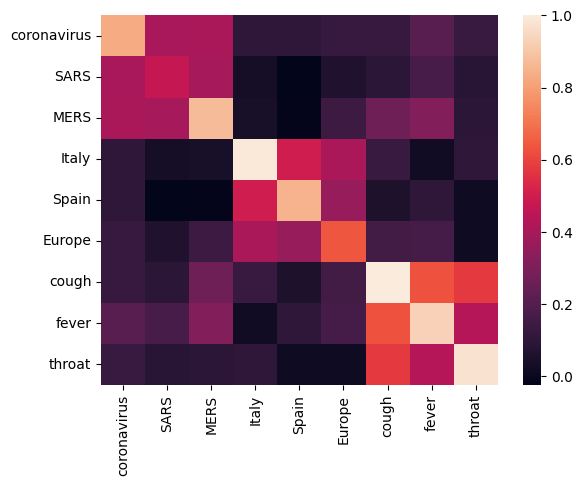

In [3]:
# Use the inner product between two embedding vectors as the similarity measure
def plot_correlation(labels, features):
  corr = np.inner(features, features)
  corr /= np.max(corr)
  sns.heatmap(corr, xticklabels=labels, yticklabels=labels)


with tf.Graph().as_default():
  # Load the module
  query_input = tf.placeholder(tf.string)
  module = hub.Module('https://tfhub.dev/tensorflow/cord-19/swivel-128d/1')
  embeddings = module(query_input)

  with tf.train.MonitoredTrainingSession() as sess:

    # Generate embeddings for some terms
    queries = [
        # Related viruses
        "coronavirus", "SARS", "MERS",
        # Regions
        "Italy", "Spain", "Europe",
        # Symptoms
        "cough", "fever", "throat"
    ]

    features = sess.run(embeddings, feed_dict={query_input: queries})
    plot_correlation(queries, features)

可以看到，嵌入向量成功捕获了不同术语的含义。每个单词都与其所在簇的其他单词相似（即“coronavirus”与“SARS”和“MERS”高度相关），但与其他簇的术语不同（即“SARS”与“Spain”之间的相似度接近于 0）。

现在，我们来看看如何使用这些嵌入向量解决特定任务。

## SciCite：引用意图分类

本部分介绍了将嵌入向量用于下游任务（如文本分类）的方法。我们将使用 TensorFlow 数据集中的 [SciCite 数据集](https://tensorflow.google.cn/datasets/catalog/scicite)对学术论文中的引文意图进行分类。给定一个带有学术论文引文的句子，对引用的主要意图进行分类：是背景信息、使用方法，还是比较结果。

In [4]:
#@title Set up the dataset from TFDS

class Dataset:
  """Build a dataset from a TFDS dataset."""
  def __init__(self, tfds_name, feature_name, label_name):
    self.dataset_builder = tfds.builder(tfds_name)
    self.dataset_builder.download_and_prepare()
    self.feature_name = feature_name
    self.label_name = label_name
  
  def get_data(self, for_eval):
    splits = THE_DATASET.dataset_builder.info.splits
    if tfds.Split.TEST in splits:
      split = tfds.Split.TEST if for_eval else tfds.Split.TRAIN
    else:
      SPLIT_PERCENT = 80
      split = "train[{}%:]".format(SPLIT_PERCENT) if for_eval else "train[:{}%]".format(SPLIT_PERCENT)
    return self.dataset_builder.as_dataset(split=split)

  def num_classes(self):
    return self.dataset_builder.info.features[self.label_name].num_classes

  def class_names(self):
    return self.dataset_builder.info.features[self.label_name].names

  def preprocess_fn(self, data):
    return data[self.feature_name], data[self.label_name]

  def example_fn(self, data):
    feature, label = self.preprocess_fn(data)
    return {'feature': feature, 'label': label}, label


def get_example_data(dataset, num_examples, **data_kw):
  """Show example data"""
  with tf.Session() as sess:
    batched_ds = dataset.get_data(**data_kw).take(num_examples).map(dataset.preprocess_fn).batch(num_examples)
    it = tf.data.make_one_shot_iterator(batched_ds).get_next()
    data = sess.run(it)
  return data


TFDS_NAME = 'scicite' #@param {type: "string"}
TEXT_FEATURE_NAME = 'string' #@param {type: "string"}
LABEL_NAME = 'label' #@param {type: "string"}
THE_DATASET = Dataset(TFDS_NAME, TEXT_FEATURE_NAME, LABEL_NAME)

In [5]:
#@title Let's take a look at a few labeled examples from the training set
NUM_EXAMPLES = 20  #@param {type:"integer"}
data = get_example_data(THE_DATASET, NUM_EXAMPLES, for_eval=False)
display_df(
    pd.DataFrame({
        TEXT_FEATURE_NAME: [ex.decode('utf8') for ex in data[0]],
        LABEL_NAME: [THE_DATASET.class_names()[x] for x in data[1]]
    }))

string       label
0   The finding that BMI is closely related to TBF...      result
1   The average magnitude of the NBR increases wit...  background
2   It has been reported that NF-κB activation can...      result
3   , 2008; Quraan and Cheyne, 2008; Quraan and Ch...  background
4   5B), but, interestingly, they shared conserved...  background
5   Some investigators have noted an association o...  background
6   In our previous study, it is documented that b...  background
7   These subjects have intact cognitive function ...  background
8   Another study reported improved knee function ...  background
9   C. Data Analysis Transcription Speech samples ...      method
10  o) was administered 14 days after the inductio...      method
11  showed that individuals who had previously exp...      result
12  However, a more stringent microarray experimen...  background
13  These results, of a fast short term depression...      result
14  The proportion of laboratory confirmed cases (...  background
15  Scientometric studies employing bibliometric a...      method
16  Our choice of studying CFI in higher detail is...  background
17  5 mg), GST-53BP2(715-1005) (1 mg), GST-GL(1-25...  background
18  DCS is preferable to External Storage (ES) at ...  background
19  RDo, where RD, RF and RDo represent relative d...      method

## 训练引用意图分类器

我们将使用 Estimator 在 [SciCite 数据集](https://tensorflow.google.cn/datasets/catalog/scicite)上对分类器进行训练。让我们设置 input_fns，将数据集读取到模型中。

In [6]:
def preprocessed_input_fn(for_eval):
  data = THE_DATASET.get_data(for_eval=for_eval)
  data = data.map(THE_DATASET.example_fn, num_parallel_calls=1)
  return data


def input_fn_train(params):
  data = preprocessed_input_fn(for_eval=False)
  data = data.repeat(None)
  data = data.shuffle(1024)
  data = data.batch(batch_size=params['batch_size'])
  return data


def input_fn_eval(params):
  data = preprocessed_input_fn(for_eval=True)
  data = data.repeat(1)
  data = data.batch(batch_size=params['batch_size'])
  return data


def input_fn_predict(params):
  data = preprocessed_input_fn(for_eval=True)
  data = data.batch(batch_size=params['batch_size'])
  return data

我们构建一个模型，该模型使用 CORD-19 嵌入向量，并在顶部具有一个分类层。

In [7]:
def model_fn(features, labels, mode, params):
  # Embed the text
  embed = hub.Module(params['module_name'], trainable=params['trainable_module'])
  embeddings = embed(features['feature'])

  # Add a linear layer on top
  logits = tf.layers.dense(
      embeddings, units=THE_DATASET.num_classes(), activation=None)
  predictions = tf.argmax(input=logits, axis=1)

  if mode == tf.estimator.ModeKeys.PREDICT:
    return tf.estimator.EstimatorSpec(
        mode=mode,
        predictions={
            'logits': logits,
            'predictions': predictions,
            'features': features['feature'],
            'labels': features['label']
        })
  
  # Set up a multi-class classification head
  loss = tf.nn.sparse_softmax_cross_entropy_with_logits(
      labels=labels, logits=logits)
  loss = tf.reduce_mean(loss)

  if mode == tf.estimator.ModeKeys.TRAIN:
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=params['learning_rate'])
    train_op = optimizer.minimize(loss, global_step=tf.train.get_or_create_global_step())
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

  elif mode == tf.estimator.ModeKeys.EVAL:
    accuracy = tf.metrics.accuracy(labels=labels, predictions=predictions)
    precision = tf.metrics.precision(labels=labels, predictions=predictions)
    recall = tf.metrics.recall(labels=labels, predictions=predictions)

    return tf.estimator.EstimatorSpec(
        mode=mode,
        loss=loss,
        eval_metric_ops={
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
        })


In [8]:
#@title Hyperparmeters { run: "auto" }

EMBEDDING = 'https://tfhub.dev/tensorflow/cord-19/swivel-128d/1'  #@param {type: "string"}
TRAINABLE_MODULE = False  #@param {type: "boolean"}
STEPS =   8000#@param {type: "integer"}
EVAL_EVERY = 200  #@param {type: "integer"}
BATCH_SIZE = 10  #@param {type: "integer"}
LEARNING_RATE = 0.01  #@param {type: "number"}

params = {
    'batch_size': BATCH_SIZE,
    'learning_rate': LEARNING_RATE,
    'module_name': EMBEDDING,
    'trainable_module': TRAINABLE_MODULE
}

## 训练并评估模型

让我们训练并评估模型以查看在 SciCite 任务上的性能。

In [9]:
estimator = tf.estimator.Estimator(functools.partial(model_fn, params=params))
metrics = []

for step in range(0, STEPS, EVAL_EVERY):
  estimator.train(input_fn=functools.partial(input_fn_train, params=params), steps=EVAL_EVERY)
  step_metrics = estimator.evaluate(input_fn=functools.partial(input_fn_eval, params=params))
  print('Global step {}: loss {:.3f}, accuracy {:.3f}'.format(step, step_metrics['loss'], step_metrics['accuracy']))
  metrics.append(step_metrics)

2022-12-14 21:42:49.944792: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.
/tmpfs/tmp/ipykernel_55626/393120678.py:7: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  logits = tf.layers.dense(


2022-12-14 21:42:51.606735: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


Global step 0: loss 0.797, accuracy 0.659


2022-12-14 21:42:52.907787: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


2022-12-14 21:42:54.348922: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


Global step 200: loss 0.724, accuracy 0.703


2022-12-14 21:42:55.250551: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


2022-12-14 21:42:56.592261: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


Global step 400: loss 0.673, accuracy 0.732


2022-12-14 21:42:57.531646: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


2022-12-14 21:42:58.849640: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


Global step 600: loss 0.650, accuracy 0.739


2022-12-14 21:42:59.774741: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


2022-12-14 21:43:01.085012: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


Global step 800: loss 0.626, accuracy 0.757


2022-12-14 21:43:02.507653: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


2022-12-14 21:43:03.903652: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


Global step 1000: loss 0.614, accuracy 0.761


2022-12-14 21:43:04.818431: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


2022-12-14 21:43:06.357206: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


Global step 1200: loss 0.609, accuracy 0.769


2022-12-14 21:43:07.310568: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


2022-12-14 21:43:08.633451: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


Global step 1400: loss 0.586, accuracy 0.782


2022-12-14 21:43:09.557532: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


2022-12-14 21:43:10.827364: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


Global step 1600: loss 0.581, accuracy 0.783


2022-12-14 21:43:11.789486: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


2022-12-14 21:43:13.185712: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


Global step 1800: loss 0.583, accuracy 0.776


2022-12-14 21:43:14.101954: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


2022-12-14 21:43:15.381008: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


Global step 2000: loss 0.571, accuracy 0.789


2022-12-14 21:43:16.333631: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


2022-12-14 21:43:17.628058: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


Global step 2200: loss 0.573, accuracy 0.774


2022-12-14 21:43:18.569037: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


2022-12-14 21:43:19.991966: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


Global step 2400: loss 0.559, accuracy 0.793


2022-12-14 21:43:20.936393: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


2022-12-14 21:43:22.288659: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


Global step 2600: loss 0.568, accuracy 0.782


2022-12-14 21:43:23.221558: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


2022-12-14 21:43:24.532759: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


Global step 2800: loss 0.562, accuracy 0.784


2022-12-14 21:43:25.520853: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


2022-12-14 21:43:26.875396: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


Global step 3000: loss 0.566, accuracy 0.780


2022-12-14 21:43:27.829207: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


2022-12-14 21:43:29.180763: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


Global step 3200: loss 0.556, accuracy 0.785


2022-12-14 21:43:30.125850: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


2022-12-14 21:43:31.514597: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


Global step 3400: loss 0.556, accuracy 0.787


2022-12-14 21:43:32.457847: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


2022-12-14 21:43:34.149400: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


Global step 3600: loss 0.558, accuracy 0.778


2022-12-14 21:43:35.143225: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


2022-12-14 21:43:36.462402: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


Global step 3800: loss 0.556, accuracy 0.783


2022-12-14 21:43:37.454875: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


2022-12-14 21:43:38.807818: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


Global step 4000: loss 0.554, accuracy 0.782


2022-12-14 21:43:39.770718: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


2022-12-14 21:43:41.074971: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


Global step 4200: loss 0.549, accuracy 0.784


2022-12-14 21:43:42.004150: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


2022-12-14 21:43:43.315299: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


Global step 4400: loss 0.551, accuracy 0.784


2022-12-14 21:43:44.238165: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


2022-12-14 21:43:45.674709: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


Global step 4600: loss 0.544, accuracy 0.786


2022-12-14 21:43:46.644853: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


2022-12-14 21:43:47.970517: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


Global step 4800: loss 0.539, accuracy 0.793


2022-12-14 21:43:48.923991: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


2022-12-14 21:43:50.355042: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


Global step 5000: loss 0.545, accuracy 0.787


2022-12-14 21:43:51.311623: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


2022-12-14 21:43:52.737111: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


Global step 5200: loss 0.542, accuracy 0.789


2022-12-14 21:43:53.681737: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


2022-12-14 21:43:55.050884: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


Global step 5400: loss 0.543, accuracy 0.790


2022-12-14 21:43:55.994610: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


2022-12-14 21:43:57.381780: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


Global step 5600: loss 0.539, accuracy 0.791


2022-12-14 21:43:58.291692: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


2022-12-14 21:43:59.827555: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


Global step 5800: loss 0.539, accuracy 0.791


2022-12-14 21:44:00.875266: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


2022-12-14 21:44:02.150170: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


Global step 6000: loss 0.533, accuracy 0.801


2022-12-14 21:44:03.069729: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


2022-12-14 21:44:04.490394: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


Global step 6200: loss 0.540, accuracy 0.791


2022-12-14 21:44:05.437356: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


2022-12-14 21:44:06.754939: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


Global step 6400: loss 0.537, accuracy 0.791


2022-12-14 21:44:07.864979: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


2022-12-14 21:44:09.281294: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


Global step 6600: loss 0.542, accuracy 0.788


2022-12-14 21:44:10.251222: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


2022-12-14 21:44:11.561167: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


Global step 6800: loss 0.538, accuracy 0.787


2022-12-14 21:44:12.524633: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


2022-12-14 21:44:13.882438: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


Global step 7000: loss 0.529, accuracy 0.793


2022-12-14 21:44:14.833350: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


2022-12-14 21:44:16.280598: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


Global step 7200: loss 0.540, accuracy 0.792


2022-12-14 21:44:17.252976: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


2022-12-14 21:44:18.604710: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


Global step 7400: loss 0.539, accuracy 0.788


2022-12-14 21:44:19.542903: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


2022-12-14 21:44:20.944670: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


Global step 7600: loss 0.539, accuracy 0.789


2022-12-14 21:44:21.886642: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


2022-12-14 21:44:23.215022: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.


Global step 7800: loss 0.539, accuracy 0.790


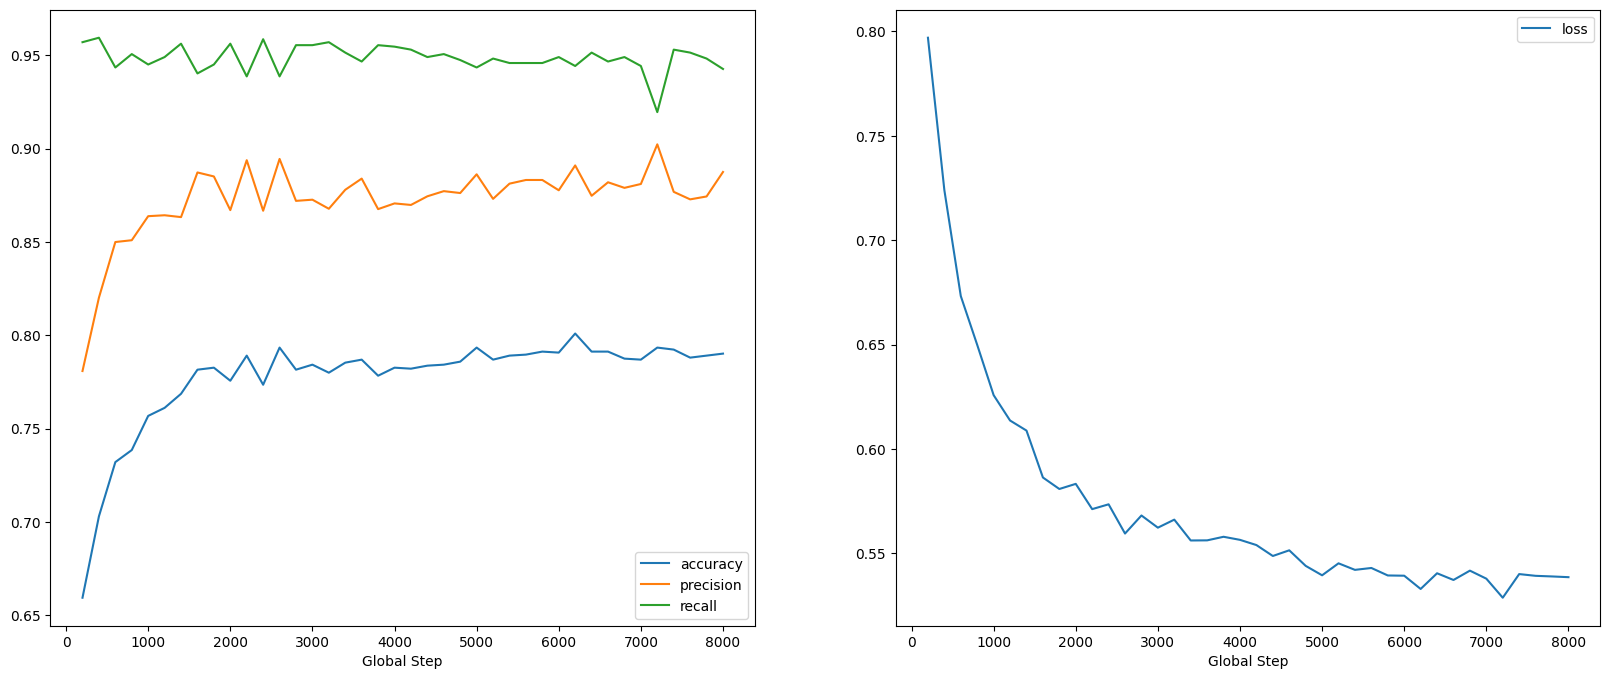

In [10]:
global_steps = [x['global_step'] for x in metrics]
fig, axes = plt.subplots(ncols=2, figsize=(20,8))

for axes_index, metric_names in enumerate([['accuracy', 'precision', 'recall'],
                                            ['loss']]):
  for metric_name in metric_names:
    axes[axes_index].plot(global_steps, [x[metric_name] for x in metrics], label=metric_name)
  axes[axes_index].legend()
  axes[axes_index].set_xlabel("Global Step")

可以看到，损失迅速减小，而准确率迅速提高。我们绘制一些样本来检查预测与真实标签的关系：

In [11]:
predictions = estimator.predict(functools.partial(input_fn_predict, params))

In [12]:
first_10_predictions = list(itertools.islice(predictions, 10))

display_df(
  pd.DataFrame({
      TEXT_FEATURE_NAME: [pred['features'].decode('utf8') for pred in first_10_predictions],
      LABEL_NAME: [THE_DATASET.class_names()[pred['labels']] for pred in first_10_predictions],
      'prediction': [THE_DATASET.class_names()[pred['predictions']] for pred in first_10_predictions]
  }))

2022-12-14 21:44:24.825812: W tensorflow/core/common_runtime/graph_constructor.cc:1526] Importing a graph with a lower producer version 27 into an existing graph with producer version 1286. Shape inference will have run different parts of the graph with different producer versions.
/tmpfs/tmp/ipykernel_55626/393120678.py:7: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  logits = tf.layers.dense(


string       label  prediction
0  The diffraction grating, LED, and split detect...  background      method
1  Our ideas are based on a previous paper [4] de...  background      method
2  Our finding is consistent with the literature ...      result      result
3  Test scores from each of the cognitive domains...      method      method
4  The optimization algorithm was set to maximize...      method      method
5  To quantify the extent of substitution saturat...      method      method
6  Examples of gesture control are based on the e...      method      method
7  The identification of these features has been ...      method      result
8  Postulated mechanisms for observed effects of ...  background  background
9  The right inferior phrenic artery is the most ...  background  background

可以看到，对于此随机样本，模型大多数时候都会预测正确的标签，这表明它可以很好地嵌入科学句子。

# 后续计划

现在，您已经对 TF-Hub 中的 CORD-19 Swivel 嵌入向量有了更多了解，我们鼓励您参加 CORD-19 Kaggle 竞赛，为从 COVID-19 相关学术文本中获得更深入的科学洞见做出贡献。

- 参加 [CORD-19 Kaggle Challenge](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge)
- 详细了解 [COVID-19 开放研究数据集 (CORD-19)](https://api.semanticscholar.org/CorpusID:216056360)
- 访问 https://tfhub.dev/tensorflow/cord-19/swivel-128d/1，参阅文档并详细了解 TF-Hub 嵌入向量
- 使用 [TensorFlow Embedding Projector](http://projector.tensorflow.org/?config=https://storage.googleapis.com/tfhub-examples/tensorflow/cord-19/swivel-128d/1/tensorboard/full_projector_config.json) 探索 CORD-19 嵌入向量空间